In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import warnings
from collections import Counter
from sklearn.feature_selection import mutual_info_classif
warnings.filterwarnings('ignore')

## 加载数据集

a） 用户基本属性信息
![](https://pu-datacastle.obs.cn-north-1.myhuaweicloud.com/pkbigdata/master.other.img/e64d443b-4dee-43dc-b5c5-3ce9ce05b05d/45274153096239234.png)

b)借贷相关信息
![](https://pu-datacastle.obs.cn-north-1.myhuaweicloud.com/pkbigdata/master.other.img/75ccb1ba-f554-4d9b-be80-94ea3b9eb68d/3380553979757217.png)

c) 用户征信相关信息
x_0至x_78以及ncloseCreditCard, unpayIndvLoan, unpayOtherLoan, unpayNormalLoan, 5yearBadloan
该部分数据涉及较为第三方敏感数据，未做进一步说明。



In [36]:
train = pd.read_csv("new_data/train.csv")
train_target = pd.read_csv('new_data/train_target.csv')
train = train.merge(train_target, on='id')
test = pd.read_csv("new_data/test.csv")
test['target']=[-1 for i in range(len(test))]
df = pd.concat([train, test], sort=False, axis=0)

In [37]:
# df['missing'] = (train==-999).sum(axis=1).astype(float)

In [38]:
# 删除重复列
duplicated_features = ['x_0', 'x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6',
                       'x_7', 'x_8', 'x_9', 'x_10', 'x_11', 'x_13',
                       'x_15', 'x_17', 'x_18', 'x_19', 'x_21',
                       'x_23', 'x_24', 'x_36', 'x_37', 'x_38', 'x_57', 'x_58',
                       'x_59', 'x_60', 'x_77', 'x_78'] + \
                      ['x_22', 'x_40', 'x_70'] + \
                      ['x_41'] + \
                      ['x_43'] + \
                      ['x_45'] + \
                      ['x_61']
df = df.drop(columns=duplicated_features)

## 数据类型，唯一值个数，缺失值统计

In [39]:
rows = train.shape[0]
columns = train.shape[1]
print("The train dataset contains {0} rows and {1} columns".format(rows, columns))
rows = test.shape[0]
columns = test.shape[1]
print("The test dataset contains {0} rows and {1} columns".format(rows, columns))
rows = df.shape[0]
columns = df.shape[1]
print("The df dataset contains {0} rows and {1} columns".format(rows, columns))


The train dataset contains 132029 rows and 105 columns
The test dataset contains 23561 rows and 105 columns
The df dataset contains 155590 rows and 69 columns


In [62]:
stats = []
for col in df.columns:
    stats.append((col, train[col].nunique(), train[col].isnull().sum() * 100 / train.shape[0],
                  train[col].value_counts(normalize=True, dropna=False).values[0] * 100, train[col].dtype))

stats_df = pd.DataFrame(stats, columns=['Feature', 'Unique_values', 'Percentage of missing values',
                                        'Percentage of values in the biggest category', 'type'])
stats_df.sort_values('Unique_values', ascending=True, inplace=True)
stats_df.head(30)

,Feature,Unique_values,Percentage of missing values,Percentage of values in the biggest category,type
68,target,2,0.0,99.273644,int64
66,5yearBadloan,2,0.0,99.763688,int64
3,gender,2,0.0,75.622022,int64
67,isNew,2,0.0,63.770838,int64
32,x_50,3,0.0,83.092351,int64
33,x_51,3,0.0,73.479311,int64
35,x_53,3,0.0,83.849003,int64
36,x_54,3,0.0,85.732680,int64
37,x_55,3,0.0,95.465390,int64
38,x_56,3,0.0,97.080944,int64


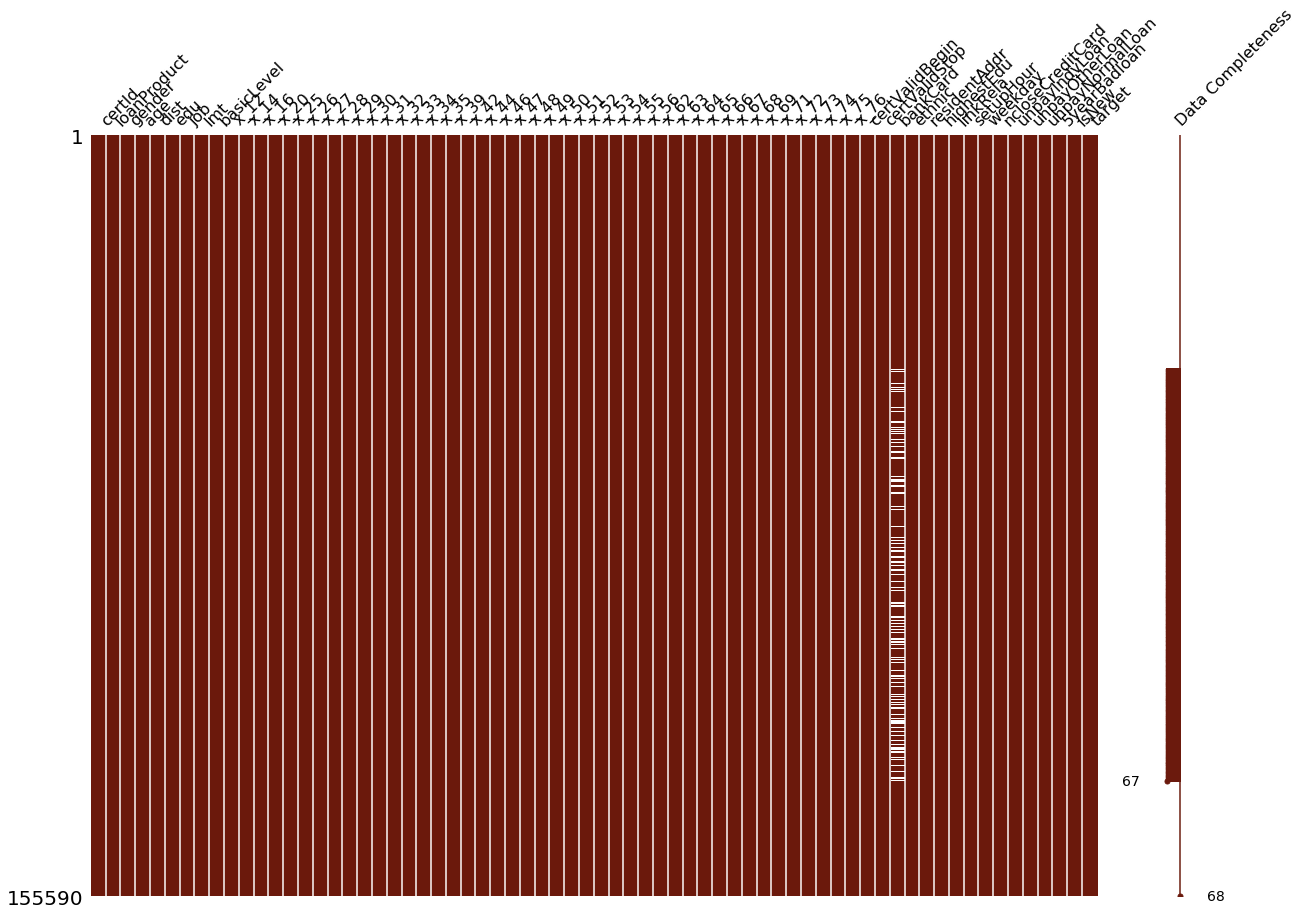

In [44]:
# 缺失值可视化显示
import missingno as msno
data=df.copy()
msno.matrix(df=data.iloc[:,1:69], figsize=(20, 14), color=(0.42, 0.1, 0.05),labels=True)

从上面统计可以得出：
- 所有的字段都可以当做类别特征
- 数值特征：['lmt','certValidStop','certValidBegin']
- 缺失值只有一列：bankCard

In [69]:
# 填充缺失值
df.fillna(value=0, inplace=True)  # bankCard存在空值
train.fillna(value=0, inplace=True)  # bankCard存在空值

## target 可视化

In [45]:
data = [go.Bar(
            x = train["target"].value_counts().index.values,
            y = train["target"].value_counts().values,
            text='Distribution of target variable'
    )]

layout = go.Layout(
    title='Target variable distribution'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

## 相关系数展示

In [56]:
train_float = df.select_dtypes(include=['float64'])
train_int = df.select_dtypes(include=['int64'])

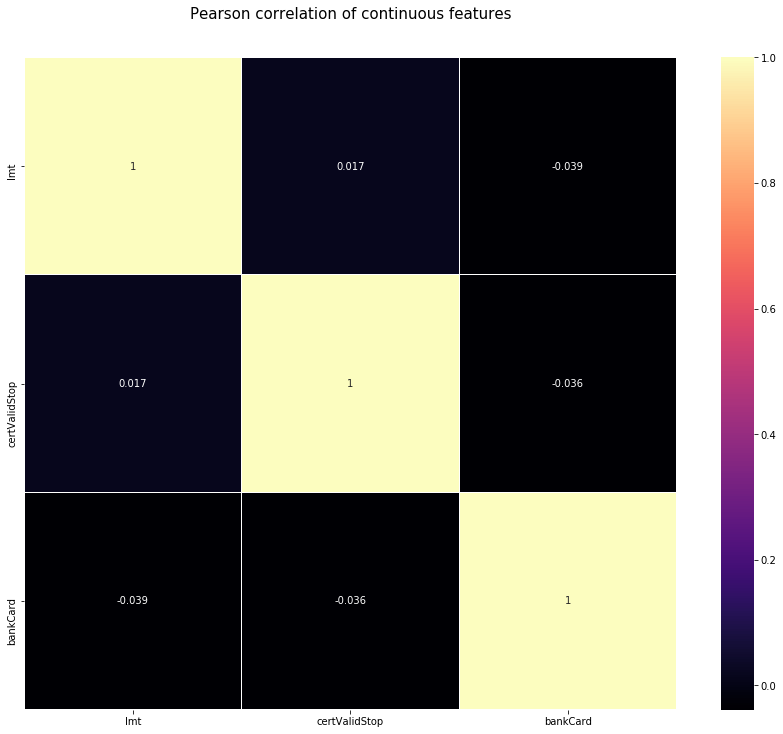

In [57]:
colormap = plt.cm.magma
plt.figure(figsize=(16,12))
plt.title('Pearson correlation of continuous features', y=1.05, size=15)
sns.heatmap(train_float.corr(),linewidths=0.1,vmax=1.0, square=True, 
            cmap=colormap, linecolor='white', annot=True)


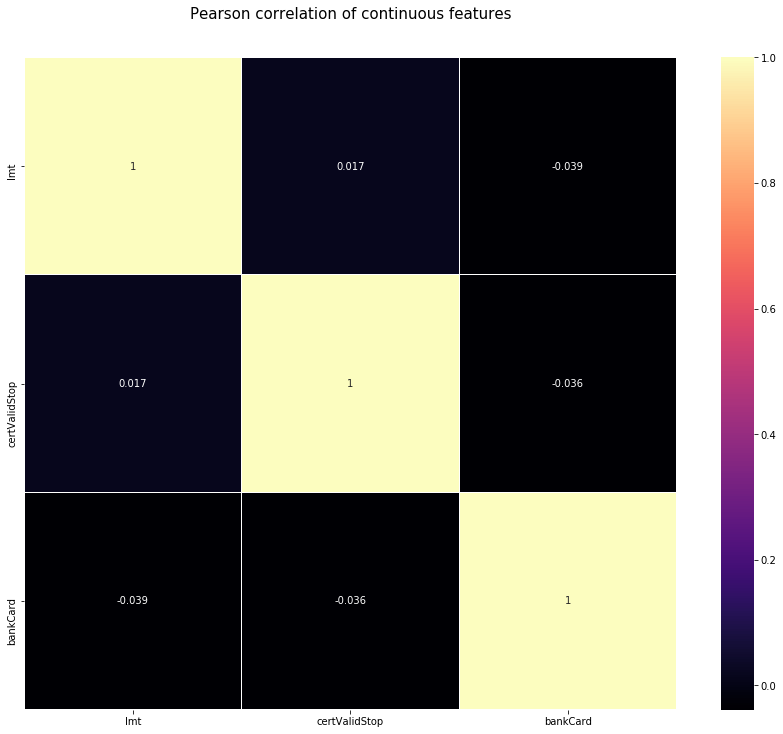

In [58]:
colormap = plt.cm.magma
plt.figure(figsize=(16,12))
plt.title('Pearson correlation of continuous features', y=1.05, size=15)
sns.heatmap(train_float.corr(),linewidths=0.1,vmax=1.0, square=True, 
            cmap=colormap, linecolor='white', annot=True)


In [59]:
data = [
    go.Heatmap(
        z= train_int.corr().values,
        x=train_int.columns.values,
        y=train_int.columns.values,
        colorscale='Viridis',
        reversescale = False,
        opacity = 1.0 )
]

layout = go.Layout(
    title='Pearson Correlation of Integer-type features',
    xaxis = dict(ticks='', nticks=36),
    yaxis = dict(ticks='' ),
    width = 900, height = 700)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='labelled-heatmap')

## 01 类别特征展示

In [66]:
bin_col = ['5yearBadloan','isNew']
zero_list = []
one_list = []
for col in bin_col:
    zero_list.append((train[col]==0).sum())
    one_list.append((train[col]==1).sum())

In [67]:
trace1 = go.Bar(
    x=bin_col,
    y=zero_list ,
    name='Zero count'
)
trace2 = go.Bar(
    x=bin_col,
    y=one_list,
    name='One count'
)

data = [trace1, trace2]
layout = go.Layout(
    barmode='stack',
    title='Count of 1 and 0 in binary variables'
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='stacked-bar')


## 特征重要性展示

In [70]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(n_estimators=100, max_depth=3, min_samples_leaf=4, max_features=0.2, random_state=0)
gb.fit(train.drop(['id', 'target'],axis=1), train.target)
features = train.drop(['id', 'target'],axis=1).columns.values
print("----- Training Done -----")

----- Training Done -----


In [72]:
# Scatter plot 
trace = go.Scatter(
    y = gb.feature_importances_,
    x = features,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 13,
        #size= rf.feature_importances_,
        #color = np.random.randn(500), #set color equal to a variable
        color = gb.feature_importances_,
        colorscale='Portland',
        showscale=True
    ),
    text = features
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Gradient Boosting Machine Feature Importance',
    hovermode= 'closest',
     xaxis= dict(
         ticklen= 5,
         showgrid=False,
        zeroline=False,
        showline=False
     ),
    yaxis=dict(
        title= 'Feature Importance',
        showgrid=False,
        zeroline=False,
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

In [73]:
x, y = (list(x) for x in zip(*sorted(zip(gb.feature_importances_, features), 
                                                            reverse = False)))
trace2 = go.Bar(
    x=x ,
    y=y,
    marker=dict(
        color=x,
        colorscale = 'Viridis',
        reversescale = True
    ),
    name='Gradient Boosting Classifer Feature importance',
    orientation='h',
)

layout = dict(
    title='Barplot of Feature importances',
     width = 900, height = 2000,
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True,
    ))

fig1 = go.Figure(data=[trace2])
fig1['layout'].update(layout)
py.iplot(fig1, filename='plots')